- CNN pour la clacification du dataset avec les 10 catégorie https://keras.io/api/datasets/cifar10/
- Model inspiration : [link](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)
- Fine tuning de mobilenet (ajout d'un dense layer pour catégorisation)

## Step 0: Mac M2 GPU

- The Neural Engine is primarily used for inference through Core ML
- TensorFlow training uses the GPU cores via Metal Performance Shaders (MPS)
- As of 2024, use Python 3.11 with TensorFlow 2.15.1 and tensorflow-metal 1.1.0 for best compatibility

In [88]:
%pip install tensorflow-metal
%pip install tensorflow-macos

# Step 1: System Information and TensorFlow Configuration
import sys
import platform
import subprocess
import tensorflow as tf

print("="*80)
print(" "*25 + "SYSTEM INFORMATION")
print("="*80)

# System details
print(f"\n📱 Platform: {platform.platform()}")
print(f"🏗️ Architecture: {platform.machine()}")
print(f"🐍 Python Version: {sys.version}")
print(f"📦 TensorFlow Version: {tf.__version__}")

# Check for tensorflow-metal
try:
    import tensorflow_metal
    print(f"TensorFlow Metal: Installed")
except ImportError:
    print("TensorFlow Metal: Not installed - GPU acceleration unavailable!")
    print("   Install with: pip install tensorflow-metal")

# Check macOS version
try:
    macos_version = subprocess.check_output(['sw_vers', '-productVersion']).decode().strip()
    print(f"macOS Version: {macos_version}")
    
    # Verify minimum version (12.0 required for Metal)
    major, minor = map(int, macos_version.split('.')[:2])
    if major < 12:
        print("WARNING: macOS 12.0+ required for Metal GPU support!")
except:
    pass

print("\n" + "="*80)
print(" "*25 + "GPU DETECTION & VERIFICATION")
print("="*80)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
                         SYSTEM INFORMATION

📱 Platform: macOS-15.6.1-arm64-arm-64bit
🏗️ Architecture: arm64
🐍 Python Version: 3.11.13 (main, Jun  5 2025, 08:21:08) [Clang 14.0.6 ]
📦 TensorFlow Version: 2.16.2
TensorFlow Metal: Not installed - GPU acceleration unavailable!
   Install with: pip install tensorflow-metal
macOS Version: 15.6.1

                         GPU DETECTION & VERIFICATION


In [89]:
# Step 2: GPU Detection and Configuration
print("\n Detecting available devices...")

# List all physical devices
devices = tf.config.list_physical_devices()
print(f"\nAll devices found: {len(devices)}")
for device in devices:
    print(f"   - {device}")

# Check specifically for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\nGPU DETECTED! Found {len(gpus)} GPU device(s)")
    for i, gpu in enumerate(gpus):
        print(f"\nGPU {i} Details:")
        print(f"   Device: {gpu}")
        try:
            details = tf.config.experimental.get_device_details(gpu)
            for key, value in details.items():
                print(f"   {key}: {value}")
        except:
            print(" (Unable to get detailed GPU information)")
    
    # Configure GPU memory growth
    print("\n Configuring GPU memory growth...")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(" Memory growth enabled - GPU will allocate memory as needed")
    except RuntimeError as e:
        print(f" Could not set memory growth: {e}")
        
else:
    print("\n NO GPU DETECTED!")
    print("   Possible reasons:")
    print("   1. tensorflow-metal not installed")
    print("   2. Incompatible TensorFlow version")
    print("   3. System doesn't have compatible GPU")
    print("\n   To install tensorflow-metal:")
    print("   pip install tensorflow-metal==1.1.0")

# Enable device placement logging
print("\n📍 Enabling device placement logging...")
tf.debugging.set_log_device_placement(False)


 Detecting available devices...

All devices found: 2
   - PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
   - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

GPU DETECTED! Found 1 GPU device(s)

GPU 0 Details:
   Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
   device_name: METAL

 Configuring GPU memory growth...
 Memory growth enabled - GPU will allocate memory as needed

📍 Enabling device placement logging...


# Step 1: Initialisation

In [90]:
# MINIMAL REQUIREMENTS 

# Python 
import sys
assert sys.version_info >= (3,11)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# COLAB DETECTION 

try:
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TENSORFLOW
import tensorflow as tf
assert tf.__version__ >= "2.16"


# COMMON IMPORTS
import numpy as np
import os
from datetime import datetime


# REPRODUCTIBILITY
np.random.seed(42)
tf.random.set_seed(42)

# MATPLOTLIB CONFIGURATION
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)




# Step 2: load the data

In [91]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = cifar10.load_data()


# Step : Data preparation

In [92]:
# Create the validation set from the train set
# Take 20% (0.2) of the total set (50000 * 0.2 = 10000 record)
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# One hot encode target values
y_train_new = tf.keras.utils.to_categorical(y_train_new, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)
y_test  = tf.keras.utils.to_categorical(y_test, 10)

# Format in float32 and normalize to [0,1]
X_train_new = X_train_new.astype('float32') / 255.0
X_val       = X_val.astype('float32') / 255.0
X_test      = X_test.astype('float32') / 255.0

# Define class name
classNames = ['airplane','automobile','bird','cat','deer',
              'dog','frog','horse','ship','truck']




# Step : Display data and stuff

(40000, 10)
(10000, 10)
(10000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


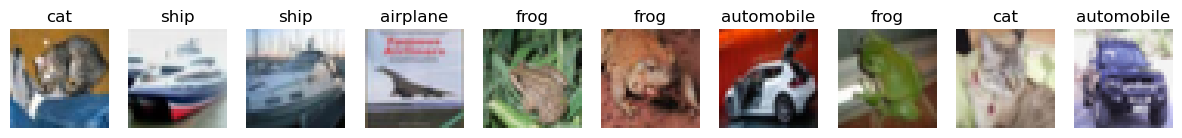

In [93]:
print(y_train_new.shape)
print(y_val.shape)
print(y_test.shape)

print(y_train_new[0])
print(y_val[0])
print(y_test[0])

fig, ax = plt.subplots(1, 10, figsize=(15,2))
for i in range(10):
    ax[i].axis('off')
    cls_idx = np.argmax(y_test[i])
    ax[i].set_title(classNames[cls_idx])
    ax[i].imshow(X_test[i])
plt.show()

# Step : Define models

In [94]:
'''
    small : Start simple
    - Layer 1 : 2 x (Conv 32 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
    - Layer 2 : 2 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
    - Layer 3 : Flatten + Dense 128 + BatchNorm + Dropout(0.5) + Dense soft max

    medium : Add 1 layer with Conv 128
    - Layer 1 : 2 x (Conv 32 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
    - Layer 2 : 2 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
    - Layer 3 : 2 x (Conv 128 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 4) + Dropout(0.3)
    - Layer 4 : Flatten + Dense 128 + BatchNorm + Dropout(0.5) + Dense soft max

    large : Add 1 Conv in each layer
    - Layer 1 : 3 x (Conv 32 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
    - Layer 2 : 3 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
    - Layer 3 : 3 x (Conv 128 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 4) + Dropout(0.3)
    - Layer 4 : Flatten + Dense 128 + BatchNorm + Dropout(0.5) + Dense soft max

    X-Large : Double filters on each layer + adapte dense layer to match
    - Layer 1 : 3 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
    - Layer 2 : 3 x (Conv 128 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
    - Layer 3 : 3 x (Conv 256 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 4) + Dropout(0.3)
    - Layer 4 : Flatten + Dense 256 + BatchNorm + Dropout(0.5) + Dense soft max

    X_large_gap : Switch to GlobalAveragePooling2D + reduce dense layer to 128
    - Layer 1 : 3 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
    - Layer 2 : 3 x (Conv 128 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
    - Layer 3 : 3 x (Conv 256 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 4) + Dropout(0.3)
    - Layer 4 : GlobalAveragePooling2D + Dense 128 + BatchNorm + Dropout(0.5) + Dense soft max

'''

def create_model(model_name="small"):
    if model_name == "small":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])

    elif model_name == "medium":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Block 3
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.3),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])

    elif model_name == "large":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Block 3
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.3),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])

    elif model_name == "X_large":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Block 3
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.3),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])
        
    elif model_name == "X_large_gap":    
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Block 3
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.3),

            # Global Average Pooling + Dense
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    return model


# Step : Define optimizers

In [95]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)


# Step : Compile and display the model

In [96]:

model = create_model("small") 
model.compile(loss="categorical_crossentropy",
              optimizer=opt, 
              metrics=['accuracy'])
# Show model shape
model.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_205 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_239         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_206 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_240         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_120 (Dropout)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_207 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_241         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_208 (Conv2D)             │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_242         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_243         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 592,554 (2.26 MB)

 Trainable params: 591,914 (2.26 MB)

 Non-trainable params: 640 (2.50 KB)

# Step : Preprocess for training

In [97]:
batch_size = 64

train_ds = (tf.data.Dataset.from_tensor_slices((X_train_new, y_train_new))
            .shuffle(10000)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))


# Step : Train the small model

In [98]:
history_small = model.fit(train_ds, epochs=1, validation_data=val_ds)

625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4757 - loss: 1.5671 - val_accuracy: 0.6221 - val_loss: 1.0631


# Step : Define Plot function

In [99]:

def plot_result(history):
    # Create subplots for Accuracy and Loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Accuracy
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Val')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim([0, 1])
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot Loss
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Val')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Step : Run plot results function

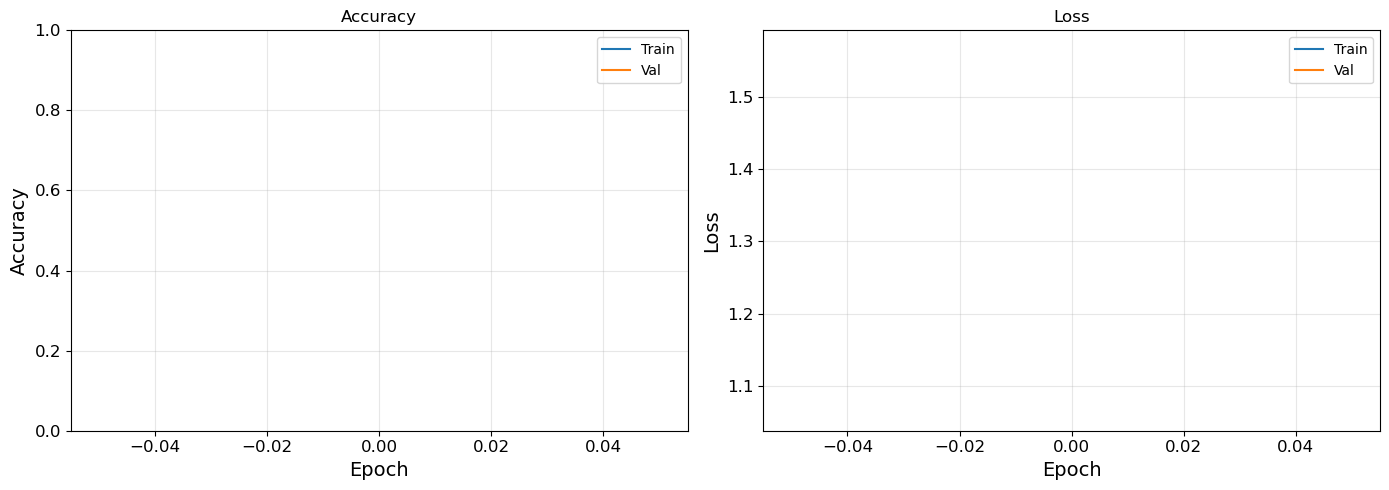

In [100]:
plot_result(history_small)

# Step : Define Evaluation function

In [101]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


def evaluate_and_report(model, X_test, y_test, class_names, batch_size=256):
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}\n")

    y_prob = model.predict(X_test, batch_size=batch_size, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    return {
        "accuracy": test_acc,
        "loss": test_loss
    }

# Step : Run Evaluation function

Test Accuracy: 0.6217



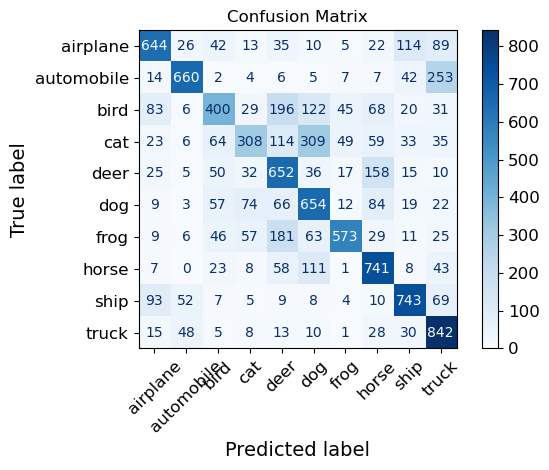

Classification Report:

              precision    recall  f1-score   support

    airplane       0.70      0.64      0.67      1000
  automobile       0.81      0.66      0.73      1000
        bird       0.57      0.40      0.47      1000
         cat       0.57      0.31      0.40      1000
        deer       0.49      0.65      0.56      1000
         dog       0.49      0.65      0.56      1000
        frog       0.80      0.57      0.67      1000
       horse       0.61      0.74      0.67      1000
        ship       0.72      0.74      0.73      1000
       truck       0.59      0.84      0.70      1000

    accuracy                           0.62     10000
   macro avg       0.64      0.62      0.62     10000
weighted avg       0.64      0.62      0.62     10000



{'accuracy': 0.6216999888420105, 'loss': 1.0680185556411743}

In [102]:
evaluate_and_report(model, X_test, y_test, class_names=classNames)

# Step : Define training and evaluation functions

In [ ]:
import os
import json
import tensorflow as tf
from types import SimpleNamespace

class TrainAndEvaluateModel:
    def __init__(self, model_name=None,
                 train_ds=None, 
                 val_ds=None,
                 optimizer=None, 
                 loss_fn=None, 
                 epochs=5,
                 callbacks=None,
                 X_test=None, 
                 y_test=None, 
                 class_names=None,
                 force=False,
                 model_summary=False,
                 base_dir="saved_models"
                 ):
        
        self.model_name = model_name
        self.train_ds = train_ds
        self.val_ds = val_ds
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.epochs = epochs
        self.callbacks = callbacks   # ✅ if None, ignored
        self.X_test = X_test
        self.y_test = y_test
        self.class_names = class_names
        self.force = force
        self.model_summary = model_summary

        # 🔥 one fixed directory per model name
        self.save_dir = os.path.join(base_dir, self.model_name)
        os.makedirs(self.save_dir, exist_ok=True)

        # Paths
        self.save_path = os.path.join(self.save_dir, f"{self.model_name}_model.keras")
        self.history_path = os.path.join(self.save_dir, f"{self.model_name}_history.json")
        self.metrics_path = os.path.join(self.save_dir, f"{self.model_name}_metrics.json")
        self.best_weights_path = os.path.join(self.save_dir, "best_model.weights.h5")

        self.model = None
        self.history = None
        self.metrics = None

    def train_model(self):
        # Case 1: Resume from best weights if they exist
        if os.path.exists(self.best_weights_path) and not self.force:
            print(f"Resuming from best checkpoint: {self.best_weights_path}")
            self.model = create_model(self.model_name)
            self.model.compile(
                loss=self.loss_fn,
                optimizer=self.optimizer,
                metrics=['accuracy']
            )
            self.model.load_weights(self.best_weights_path)

            if os.path.exists(self.history_path):
                with open(self.history_path, "r") as f:
                    loaded_history = json.load(f)
                self.history = SimpleNamespace(history=loaded_history)
            else:
                self.history = None

        # Case 2: Resume from last full model
        elif os.path.exists(self.save_path) and not self.force:
            print(f"Loading last trained model: {self.save_path}")
            self.model = tf.keras.models.load_model(self.save_path)
            self.model.compile(
                loss=self.loss_fn,
                optimizer=self.optimizer,
                metrics=['accuracy']
            )
            if os.path.exists(self.history_path):
                with open(self.history_path, "r") as f:
                    loaded_history = json.load(f)
                self.history = SimpleNamespace(history=loaded_history)
            else:
                self.history = None

        # Case 3: Train from scratch
        else:
            if self.force:
                print(f"Forcing retrain for model: {self.model_name}")
            else:
                print(f"Training new model: {self.model_name}")

            self.model = create_model(self.model_name)
            self.model.compile(
                loss=self.loss_fn,
                optimizer=self.optimizer,
                metrics=['accuracy']
            )
            if self.model_summary:
                print(f"Summary for model: {self.model_name}")
                self.model.summary()
            else:
                print("Summary disabled")

            # ✅ only pass callbacks if defined
            fit_kwargs = {
                "x": self.train_ds,
                "epochs": self.epochs,
                "verbose": 1,
                "validation_data": self.val_ds
            }
            if self.callbacks is not None:
                fit_kwargs["callbacks"] = self.callbacks

            self.history = self.model.fit(**fit_kwargs)

            # Save last full model (new .keras format)
            self.model.save(self.save_path)
            print(f"✅ Last model saved to {self.save_path}")

            with open(self.history_path, "w") as f:
                json.dump(self.history.history, f)
            print(f"✅ History saved to {self.history_path}")

        return self.model, self.history

    def load_best_weights(self):
        if os.path.exists(self.best_weights_path):
            print(f"Loading best weights from {self.best_weights_path}")
            best_model = create_model(self.model_name)
            best_model.compile(
                loss=self.loss_fn,
                optimizer=self.optimizer,
                metrics=['accuracy']
            )
            best_model.load_weights(self.best_weights_path)
            self.model = best_model
        else:
            print("⚠️ No best_model.weights.h5 found, using current model.")

    def evaluate_model(self):
        if self.history is not None:
            plot_result(self.history)

        self.metrics = evaluate_and_report(
            self.model,
            self.X_test,
            self.y_test,
            class_names=self.class_names
        )

        with open(self.metrics_path, "w") as f:
            json.dump(self.metrics, f)
        print(f"✅ Metrics saved to {self.metrics_path}")

        return self.metrics

    def run(self):
        self.train_model()
        self.load_best_weights()
        self.evaluate_model()
        return {
            "model": self.model,
            "history": self.history,
            "metrics": self.metrics
        }


# Step : Use training and evaluation function

Training model: small
Forcing retrain for model: small
Summary disabled
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.4576 - loss: 1.6202 - val_accuracy: 0.6242 - val_loss: 1.0742
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.6196 - loss: 1.0817 - val_accuracy: 0.6756 - val_loss: 0.9309
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.6766 - loss: 0.9329 - val_accuracy: 0.7102 - val_loss: 0.8288
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.7072 - loss: 0.8351 - val_accuracy: 0.7174 - val_loss: 0.8161
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.7326 - loss: 0.7659 - val_accuracy: 0.7388 - val_loss: 0.7550
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.7553 - loss: 0.7085 - val_accuracy: 0.7546 - val_loss: 0.7161
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.7695 - loss: 0.6611 - val_accuracy: 0.7377 - val_loss: 0.7715
Epoch 8/10
625/625

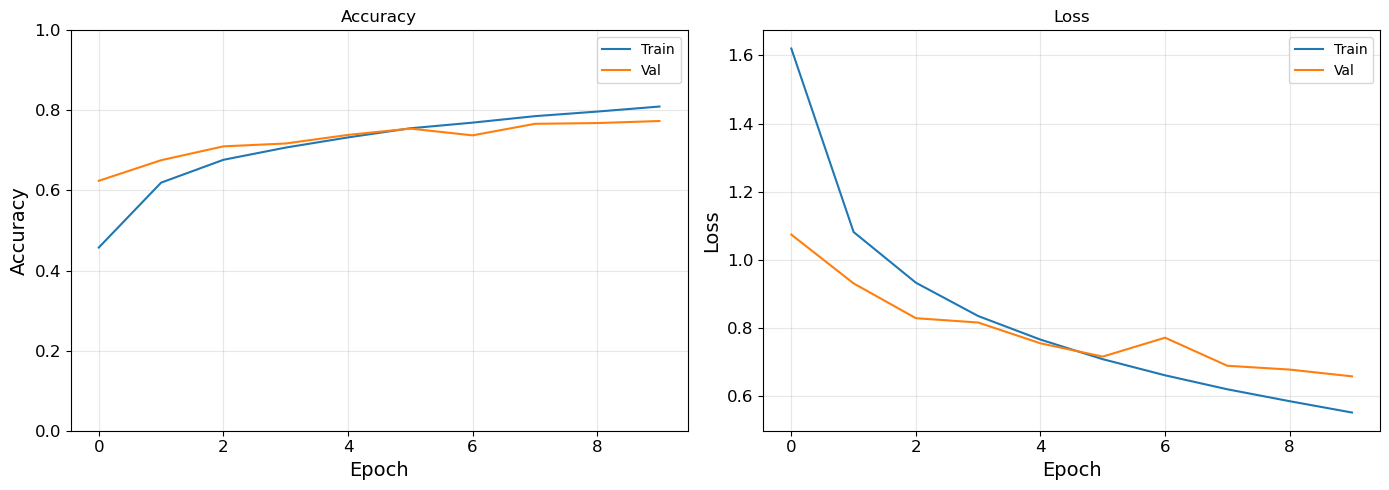

Test Accuracy: 0.7728



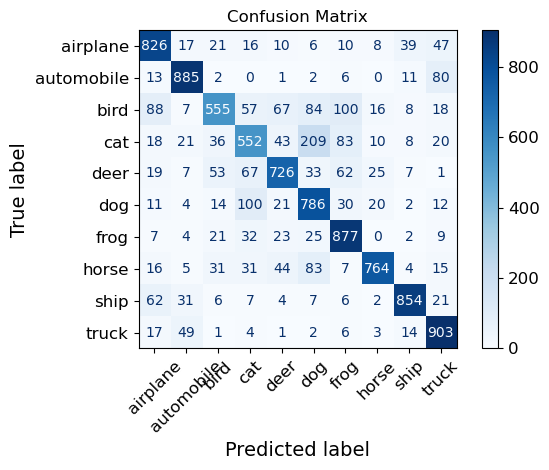

Classification Report:

              precision    recall  f1-score   support

    airplane       0.77      0.83      0.80      1000
  automobile       0.86      0.89      0.87      1000
        bird       0.75      0.56      0.64      1000
         cat       0.64      0.55      0.59      1000
        deer       0.77      0.73      0.75      1000
         dog       0.64      0.79      0.70      1000
        frog       0.74      0.88      0.80      1000
       horse       0.90      0.76      0.83      1000
        ship       0.90      0.85      0.88      1000
       truck       0.80      0.90      0.85      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000

✅ Metrics saved to saved_models/results/small/small_metrics.json
Training model: medium
Forcing retrain for model: medium
Summary disabled
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 62ms/step - accuracy: 0.4377 - los

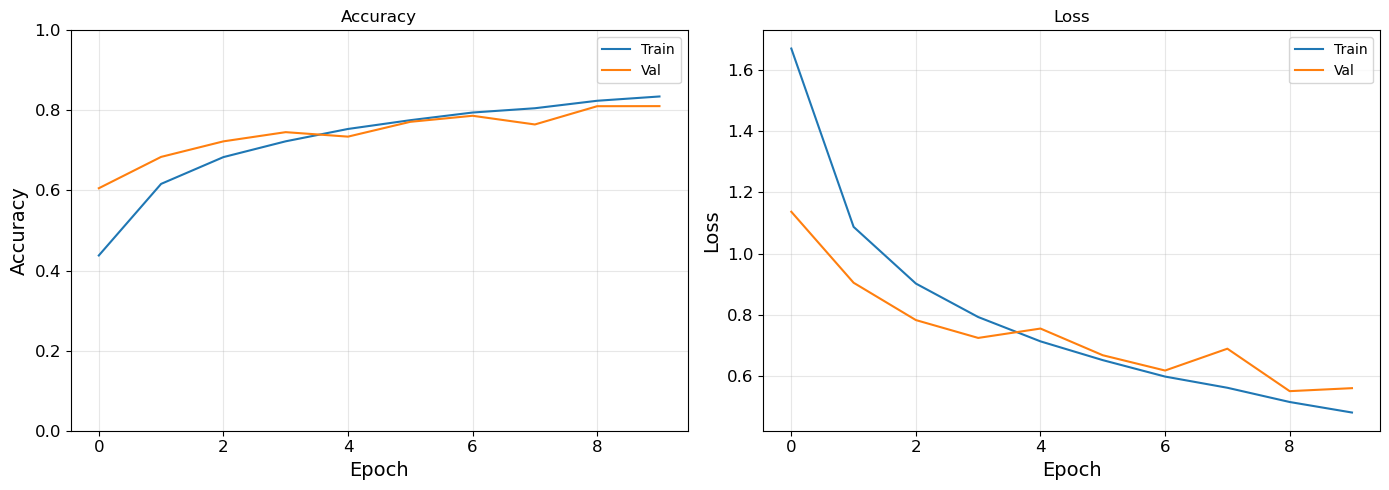

Test Accuracy: 0.8058



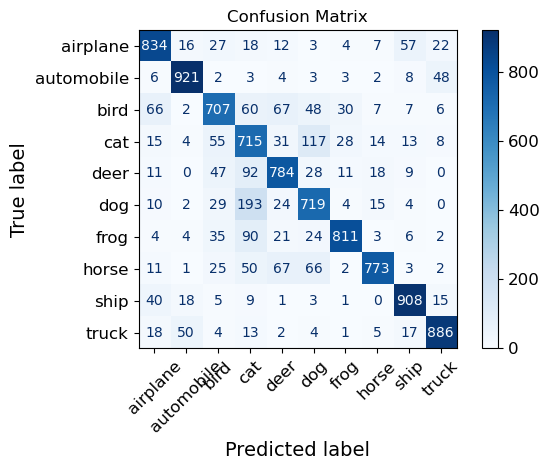

Classification Report:

              precision    recall  f1-score   support

    airplane       0.82      0.83      0.83      1000
  automobile       0.90      0.92      0.91      1000
        bird       0.76      0.71      0.73      1000
         cat       0.58      0.71      0.64      1000
        deer       0.77      0.78      0.78      1000
         dog       0.71      0.72      0.71      1000
        frog       0.91      0.81      0.86      1000
       horse       0.92      0.77      0.84      1000
        ship       0.88      0.91      0.89      1000
       truck       0.90      0.89      0.89      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

✅ Metrics saved to saved_models/results/medium/medium_metrics.json
Training model: large
Forcing retrain for model: large
Summary disabled
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 76ms/step - accuracy: 0.4193 - los

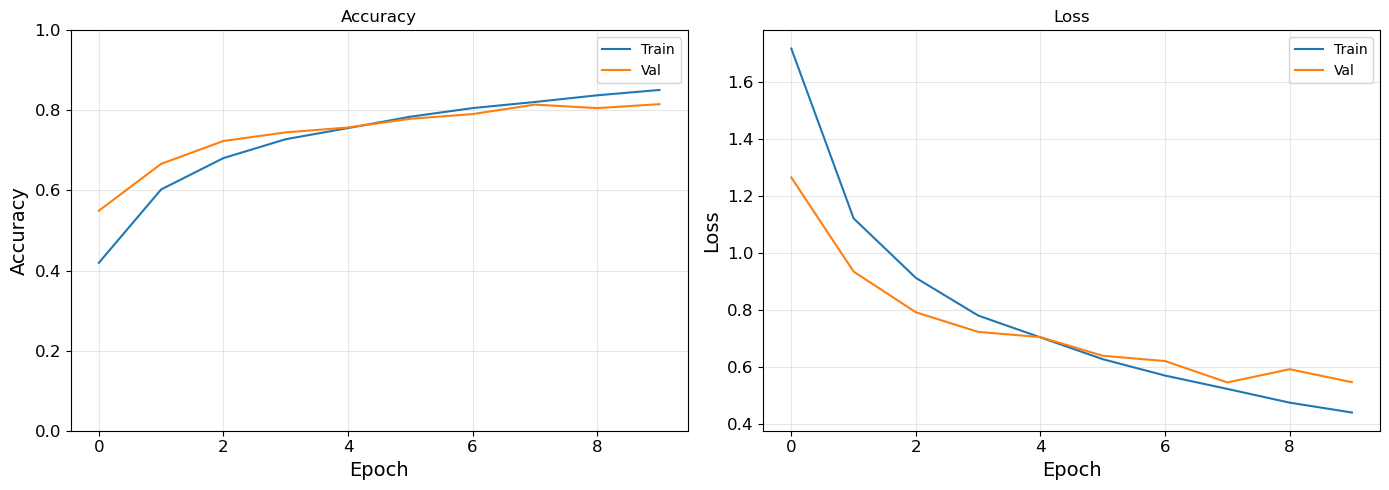

Test Accuracy: 0.8147



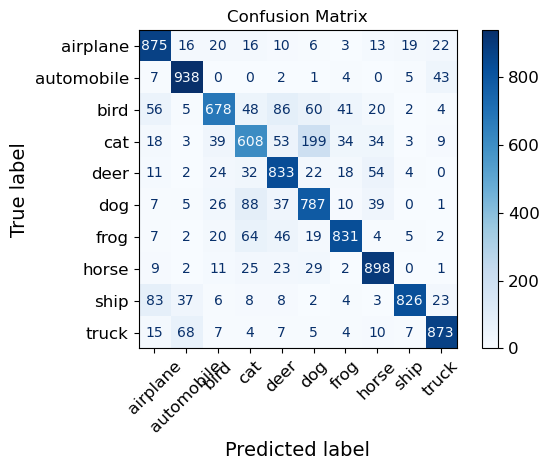

Classification Report:

              precision    recall  f1-score   support

    airplane       0.80      0.88      0.84      1000
  automobile       0.87      0.94      0.90      1000
        bird       0.82      0.68      0.74      1000
         cat       0.68      0.61      0.64      1000
        deer       0.75      0.83      0.79      1000
         dog       0.70      0.79      0.74      1000
        frog       0.87      0.83      0.85      1000
       horse       0.84      0.90      0.87      1000
        ship       0.95      0.83      0.88      1000
       truck       0.89      0.87      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000

✅ Metrics saved to saved_models/results/large/large_metrics.json
Training model: X_large
Forcing retrain for model: X_large
Summary disabled
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 77ms/step - accuracy: 0.4629 - l

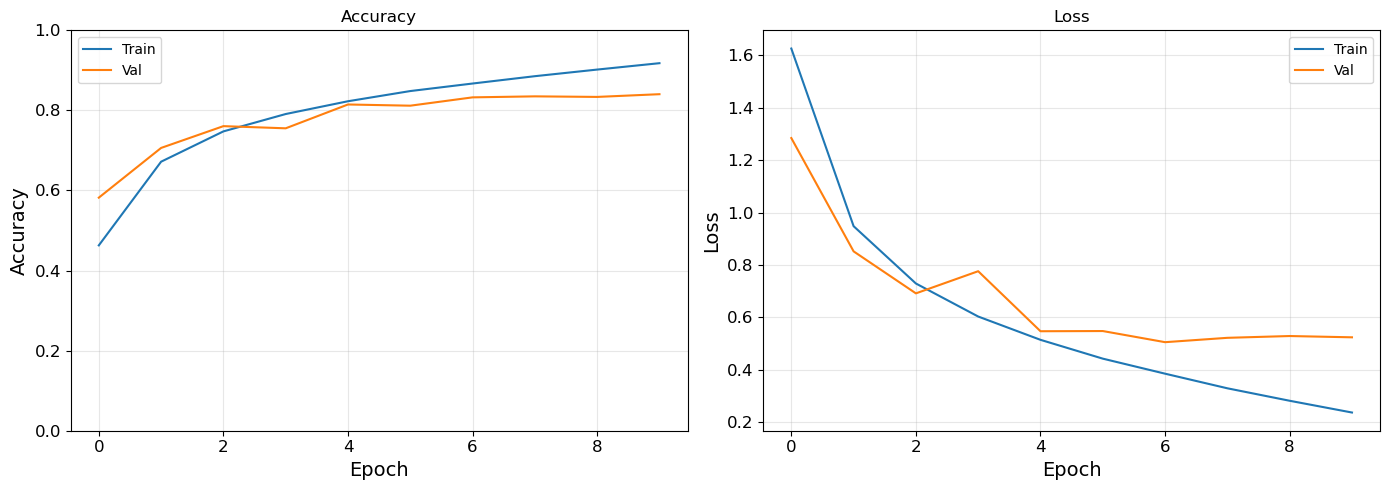

Test Accuracy: 0.8431



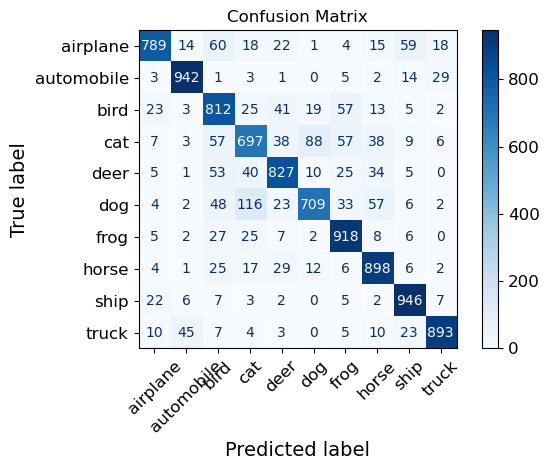

Classification Report:

              precision    recall  f1-score   support

    airplane       0.90      0.79      0.84      1000
  automobile       0.92      0.94      0.93      1000
        bird       0.74      0.81      0.77      1000
         cat       0.74      0.70      0.72      1000
        deer       0.83      0.83      0.83      1000
         dog       0.84      0.71      0.77      1000
        frog       0.82      0.92      0.87      1000
       horse       0.83      0.90      0.86      1000
        ship       0.88      0.95      0.91      1000
       truck       0.93      0.89      0.91      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

✅ Metrics saved to saved_models/results/X_large/X_large_metrics.json
Training model: X_large_gap
Forcing retrain for model: X_large_gap
Summary disabled
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy

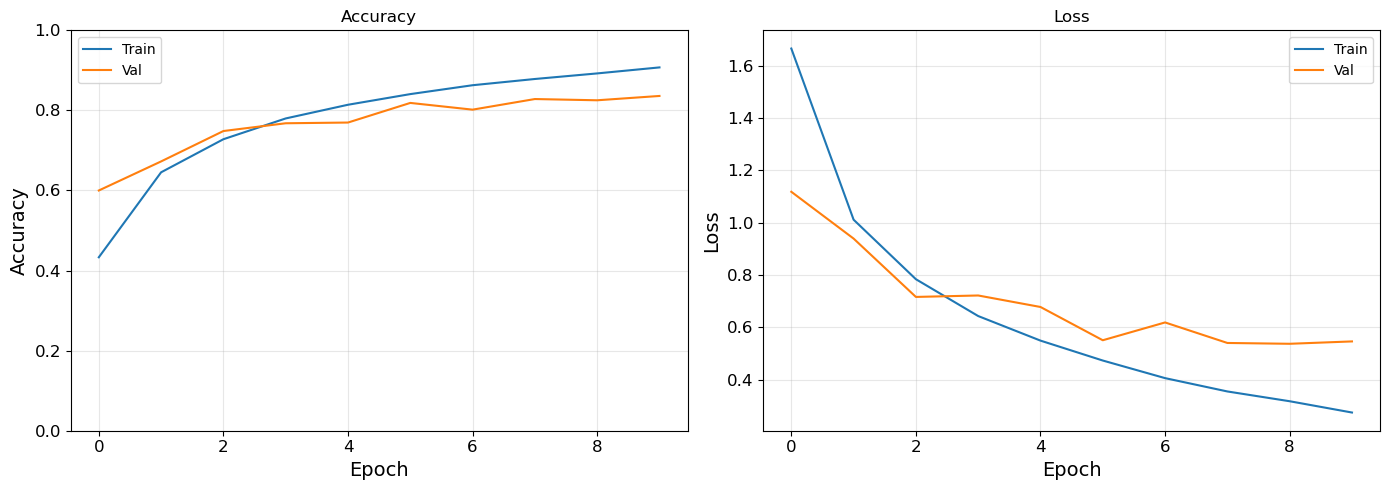

Test Accuracy: 0.8330



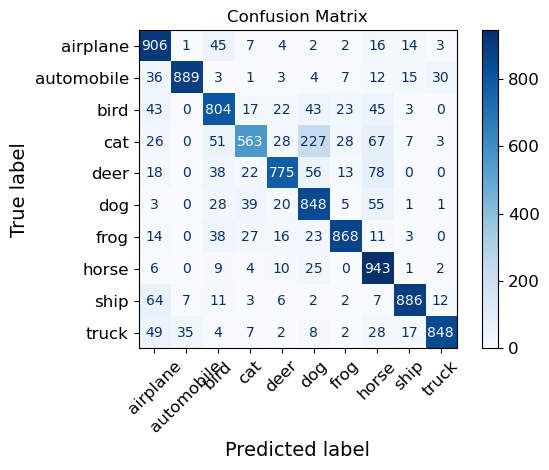

Classification Report:

              precision    recall  f1-score   support

    airplane       0.78      0.91      0.84      1000
  automobile       0.95      0.89      0.92      1000
        bird       0.78      0.80      0.79      1000
         cat       0.82      0.56      0.67      1000
        deer       0.87      0.78      0.82      1000
         dog       0.68      0.85      0.76      1000
        frog       0.91      0.87      0.89      1000
       horse       0.75      0.94      0.83      1000
        ship       0.94      0.89      0.91      1000
       truck       0.94      0.85      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000

✅ Metrics saved to saved_models/results/X_large_gap/X_large_gap_metrics.json


In [104]:
model_names = ["small", "medium", "large", "X_large", "X_large_gap"]
results = {}

for name in model_names:
    print(f"Training model: {name}")
    
    trainer = TrainAndEvaluateModel(
        model_name=name,
        train_ds=train_ds,
        val_ds=val_ds,
        optimizer=tf.keras.optimizers.Adam(),
        loss_fn="categorical_crossentropy",
        epochs=10,
        X_test=X_test,
        y_test=y_test,
        class_names=classNames,
        force=True,
        base_dir="saved_models/results"
    )

    results[name] = trainer.run()


# Step : Compare models accuracy

In [105]:
for name, result in results.items():
    acc = result["metrics"]["accuracy"]
    print(f"{name:<15} | Test Accuracy: {acc:.4f}")



small           | Test Accuracy: 0.7728
medium          | Test Accuracy: 0.8058
large           | Test Accuracy: 0.8147
X_large         | Test Accuracy: 0.8431
X_large_gap     | Test Accuracy: 0.8330


# Step : Add callback function

In [106]:

def get_callbacks(save_dir):
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        verbose=1,
        min_lr=1e-9
    )

    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_dir, "best_model.weights.h5"),
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

    earlystop_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=False,
        verbose=1
    )

    return [lr_scheduler, checkpoint_cb, earlystop_cb]


# Step : Add simple data augmentation

In [107]:
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
])

# Step : Update Preprocess for training


In [108]:
batch_size = 64

train_ds = (tf.data.Dataset.from_tensor_slices((X_train_new, y_train_new))
            .shuffle(10000)
            .batch(batch_size)
            .map(lambda x, y: (augment(x, training=True), y),
                 num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))


# Step : Train with data augmentation

Training model: small
Forcing retrain for model: small
Summary disabled
Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3036 - loss: 2.1596
Epoch 1: val_loss improved from None to 1.37937, saving model to saved_models/results2/small/best_model.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.3601 - loss: 1.8708 - val_accuracy: 0.5087 - val_loss: 1.3794 - learning_rate: 0.0010
Epoch 2/200
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4651 - loss: 1.4897
Epoch 2: val_loss improved from 1.37937 to 1.13796, saving model to saved_models/results2/small/best_model.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.4858 - loss: 1.4249 - val_accuracy: 0.5946 - val_loss: 1.1380 - learning_rate: 0.0010
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5378 - loss: 1.2812
Epoch 3: val_loss improved from 1.13796 to 1.06012, saving model to saved_models/results2/small/best_model.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━

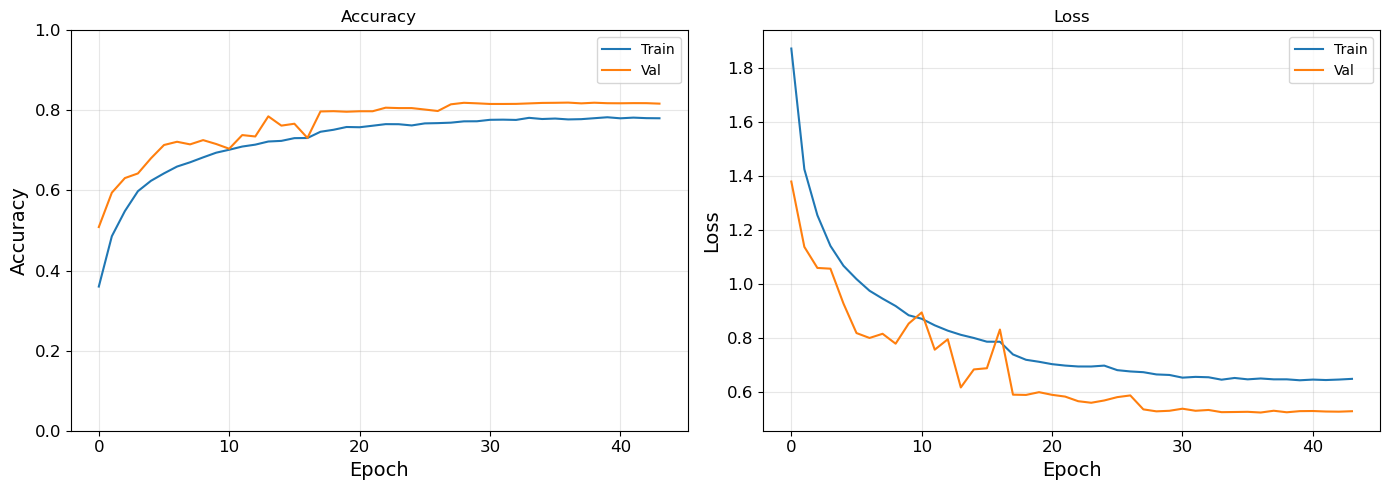

Test Accuracy: 0.8173



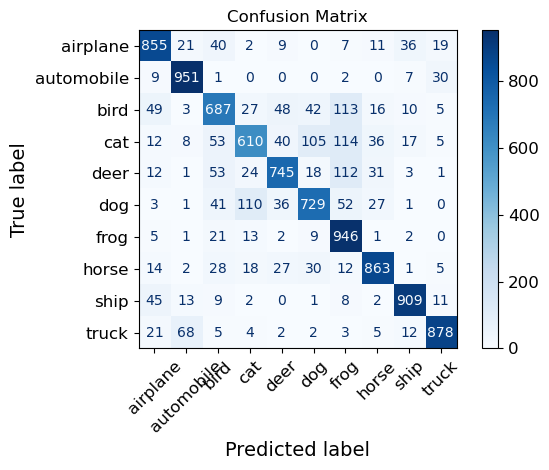

Classification Report:

              precision    recall  f1-score   support

    airplane       0.83      0.85      0.84      1000
  automobile       0.89      0.95      0.92      1000
        bird       0.73      0.69      0.71      1000
         cat       0.75      0.61      0.67      1000
        deer       0.82      0.74      0.78      1000
         dog       0.78      0.73      0.75      1000
        frog       0.69      0.95      0.80      1000
       horse       0.87      0.86      0.87      1000
        ship       0.91      0.91      0.91      1000
       truck       0.92      0.88      0.90      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

✅ Metrics saved to saved_models/results2/small/small_metrics.json
Training model: medium
Forcing retrain for model: medium
Summary disabled
Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2842 - lo

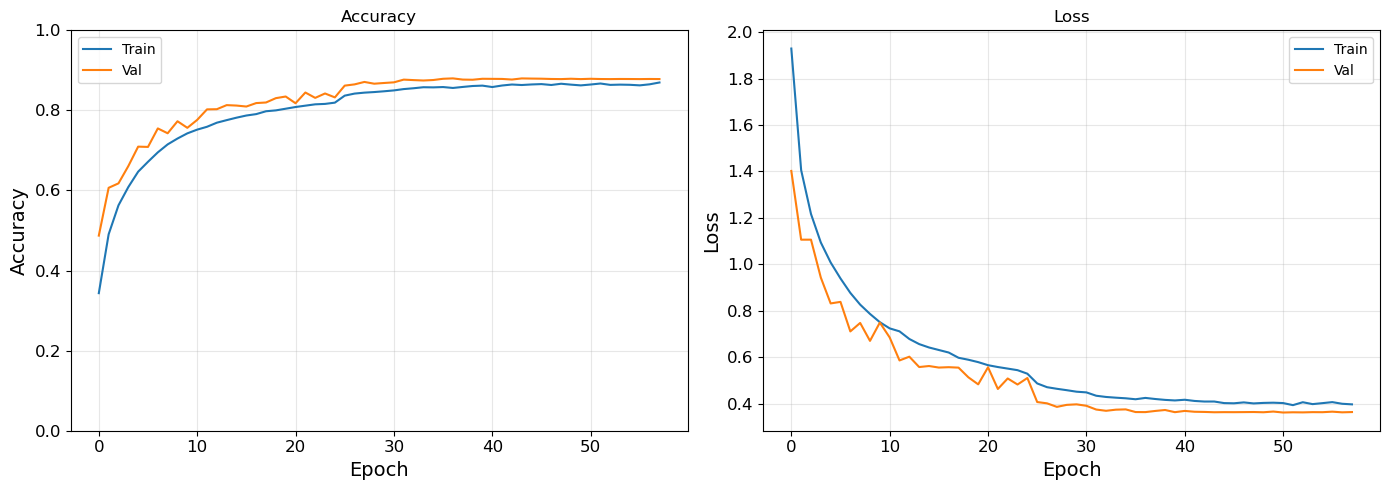

Test Accuracy: 0.8721



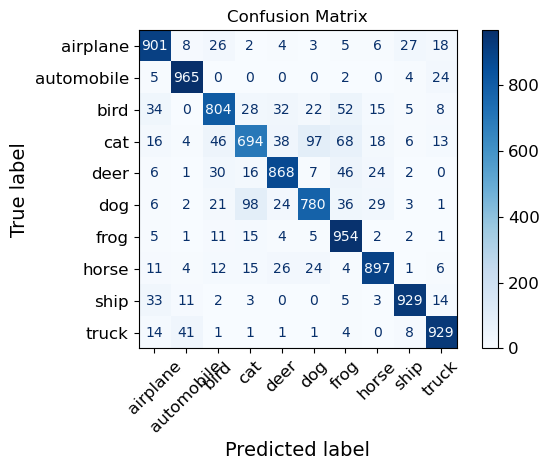

Classification Report:

              precision    recall  f1-score   support

    airplane       0.87      0.90      0.89      1000
  automobile       0.93      0.96      0.95      1000
        bird       0.84      0.80      0.82      1000
         cat       0.80      0.69      0.74      1000
        deer       0.87      0.87      0.87      1000
         dog       0.83      0.78      0.80      1000
        frog       0.81      0.95      0.88      1000
       horse       0.90      0.90      0.90      1000
        ship       0.94      0.93      0.94      1000
       truck       0.92      0.93      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

✅ Metrics saved to saved_models/results2/medium/medium_metrics.json
Training model: large
Forcing retrain for model: large
Summary disabled
Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2639 - lo

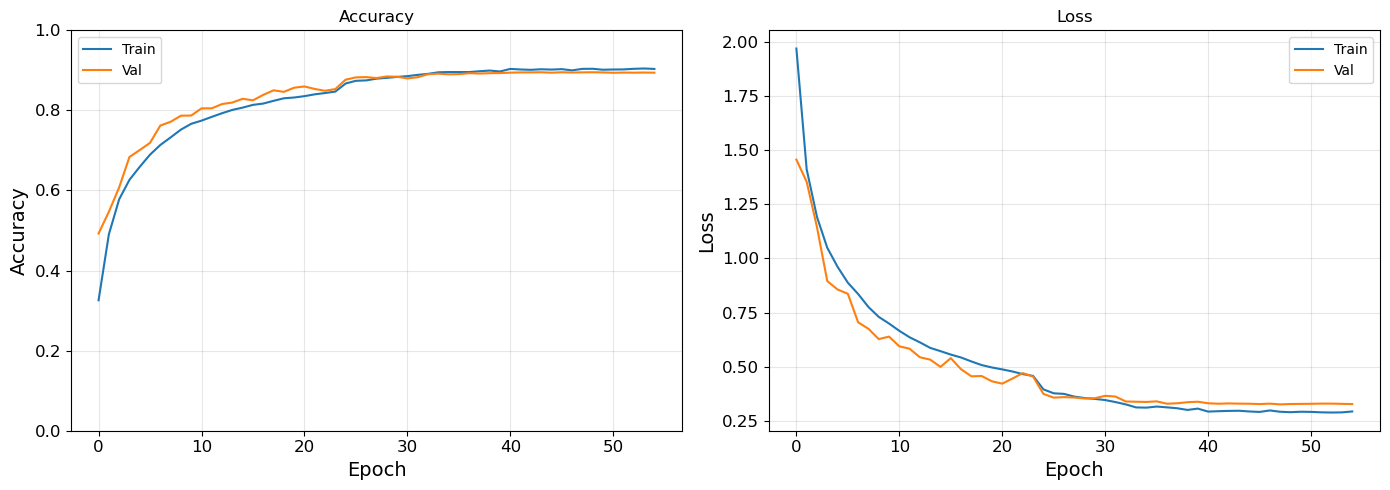

Test Accuracy: 0.8903



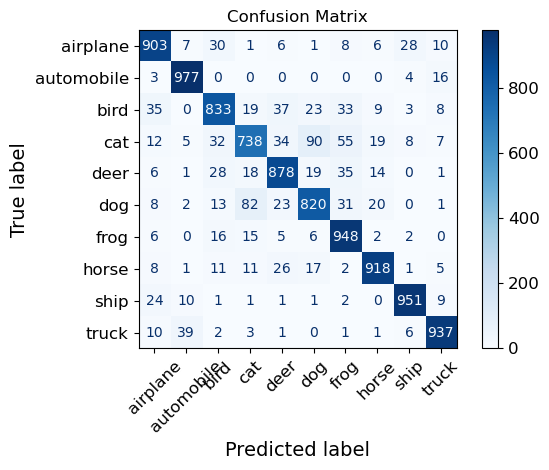

Classification Report:

              precision    recall  f1-score   support

    airplane       0.89      0.90      0.90      1000
  automobile       0.94      0.98      0.96      1000
        bird       0.86      0.83      0.85      1000
         cat       0.83      0.74      0.78      1000
        deer       0.87      0.88      0.87      1000
         dog       0.84      0.82      0.83      1000
        frog       0.85      0.95      0.90      1000
       horse       0.93      0.92      0.92      1000
        ship       0.95      0.95      0.95      1000
       truck       0.94      0.94      0.94      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

✅ Metrics saved to saved_models/results2/large/large_metrics.json
Training model: X_large
Forcing retrain for model: X_large
Summary disabled
Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3022 - 

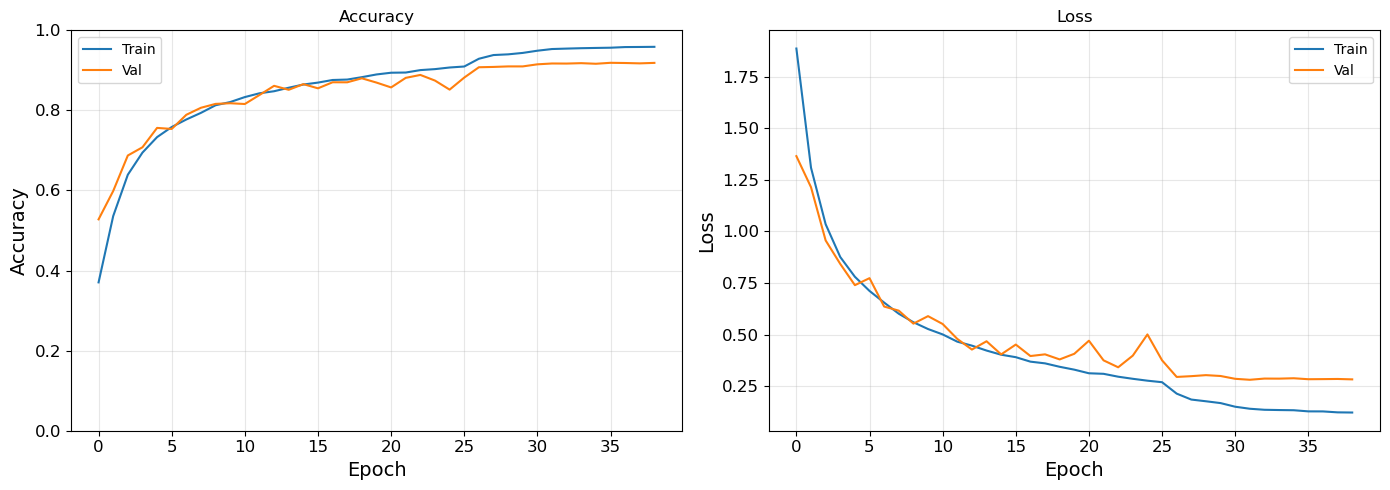

Test Accuracy: 0.9116



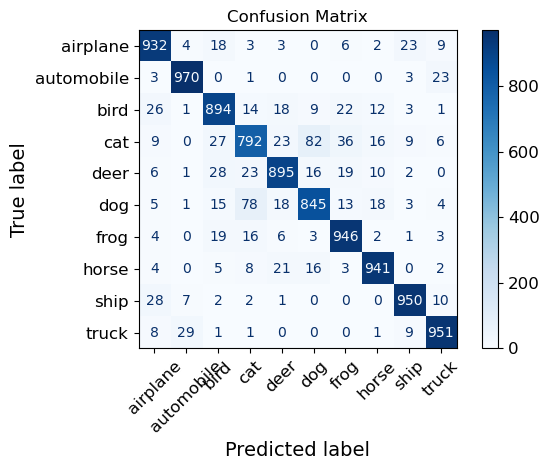

Classification Report:

              precision    recall  f1-score   support

    airplane       0.91      0.93      0.92      1000
  automobile       0.96      0.97      0.96      1000
        bird       0.89      0.89      0.89      1000
         cat       0.84      0.79      0.82      1000
        deer       0.91      0.90      0.90      1000
         dog       0.87      0.84      0.86      1000
        frog       0.91      0.95      0.93      1000
       horse       0.94      0.94      0.94      1000
        ship       0.95      0.95      0.95      1000
       truck       0.94      0.95      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

✅ Metrics saved to saved_models/results2/X_large/X_large_metrics.json
Training model: X_large_gap
Forcing retrain for model: X_large_gap
Summary disabled
Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accurac

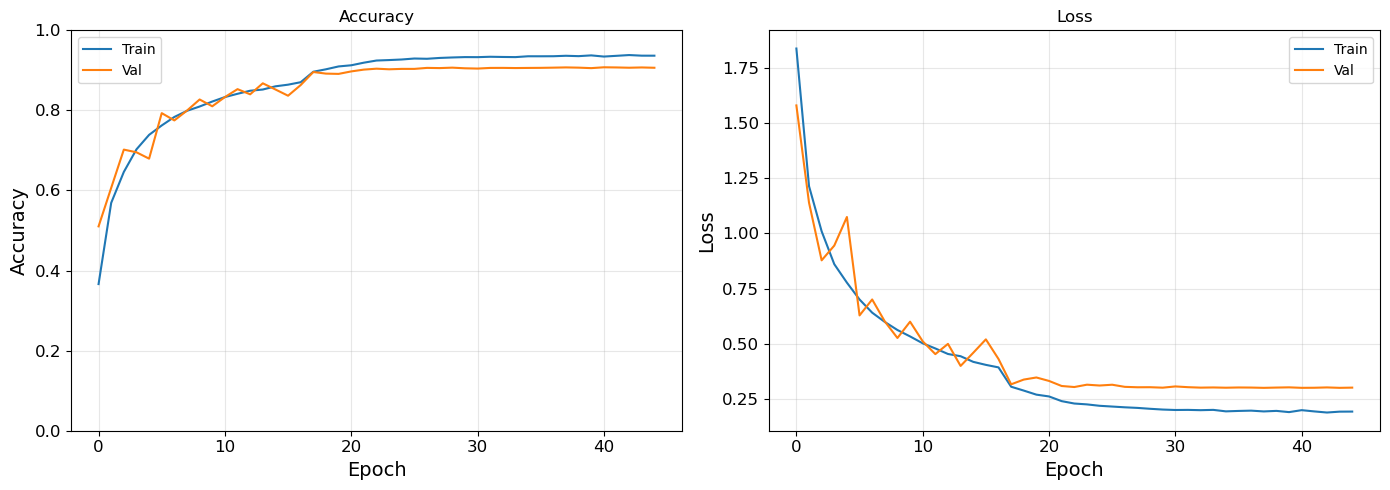

Test Accuracy: 0.9056



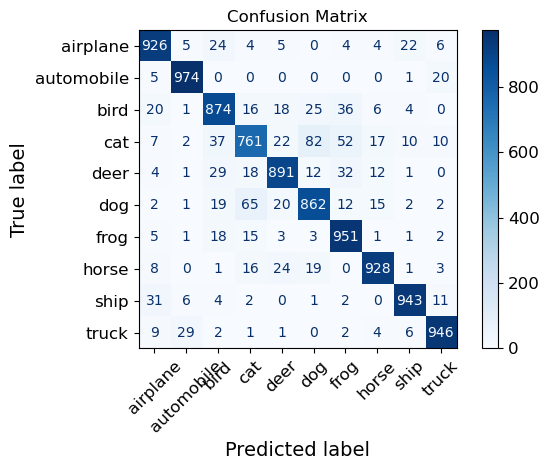

Classification Report:

              precision    recall  f1-score   support

    airplane       0.91      0.93      0.92      1000
  automobile       0.95      0.97      0.96      1000
        bird       0.87      0.87      0.87      1000
         cat       0.85      0.76      0.80      1000
        deer       0.91      0.89      0.90      1000
         dog       0.86      0.86      0.86      1000
        frog       0.87      0.95      0.91      1000
       horse       0.94      0.93      0.93      1000
        ship       0.95      0.94      0.95      1000
       truck       0.95      0.95      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

✅ Metrics saved to saved_models/results2/X_large_gap/X_large_gap_metrics.json


In [109]:
results2 = {}

for name in model_names:
    print(f"Training model: {name}")

    save_dir = os.path.join("saved_models", "results2", name)
    os.makedirs(save_dir, exist_ok=True)

    callbacks = get_callbacks(save_dir)
    
    trainer = TrainAndEvaluateModel(
        model_name=name,
        train_ds=train_ds,
        val_ds=val_ds,
        optimizer=tf.keras.optimizers.Adam(),
        loss_fn="categorical_crossentropy",
        epochs=200,
        callbacks=callbacks,
        X_test=X_test,
        y_test=y_test,
        class_names=classNames,
        force=True,
        base_dir="saved_models/results2"
    )

    results2[name] = trainer.run()


In [110]:
for name, result in results.items():
    acc = result["metrics"]["accuracy"]
    print(f"{name:<15} | Test Accuracy: {acc:.4f}")

for name, result in results2.items():
    acc = result["metrics"]["accuracy"]
    print(f"{name:<15} | Test Accuracy: {acc:.4f}")



small           | Test Accuracy: 0.7728
medium          | Test Accuracy: 0.8058
large           | Test Accuracy: 0.8147
X_large         | Test Accuracy: 0.8431
X_large_gap     | Test Accuracy: 0.8330
small           | Test Accuracy: 0.8173
medium          | Test Accuracy: 0.8721
large           | Test Accuracy: 0.8903
X_large         | Test Accuracy: 0.9116
X_large_gap     | Test Accuracy: 0.9056


# Step : GRID search cv on 2 best models


In [ ]:
# Take 2 best large and x-large and do the dropout and dense layer parametrable

def create_model(model_name="large", dropout_rates=None, dense_units=None):

    if dropout_rates is None:
        dropout_rates = {"block1": 0.1, "block2": 0.2, "block3": 0.3, "dense": 0.5}

    if model_name == "large":
        if dense_units is None:
            dense_units = 128  # default for large

        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(dropout_rates["block1"]),

            # Block 2
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(dropout_rates["block2"]),

            # Block 3
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(dropout_rates["block3"]),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(dense_units, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(dropout_rates["dense"]),
            tf.keras.layers.Dense(10, activation="softmax")
        ])

    elif model_name == "X_large":
        if dense_units is None:
            dense_units = 256  # default for X_large

        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(dropout_rates["block1"]),

            # Block 2
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(dropout_rates["block2"]),

            # Block 3
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(dropout_rates["block3"]),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(dense_units, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(dropout_rates["dense"]),
            tf.keras.layers.Dense(10, activation="softmax")
        ])

    else:
        raise ValueError(f"Unknown model name: {model_name}")

    return model


# Step : Présenter les résultat du grid search


# Step : Sauver les résultats pour les présenter dans un 3eme notebook